In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import color, exposure, measure, morphology, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

In [ ]:
# File paths
ct_dir_path = Path(r'../data/IDOX_EstaneNP/IDOX_EstaneNP_AHE')
save_images = False
save_dir_path = Path(r'../data/IDOX_EstaneNP/IDOX_EstaneNP_AHE_labeled')

Loading images...
--> Images loaded as 3D array:  (1012, 630, 630)
Plotting images: [100, 450, 800]


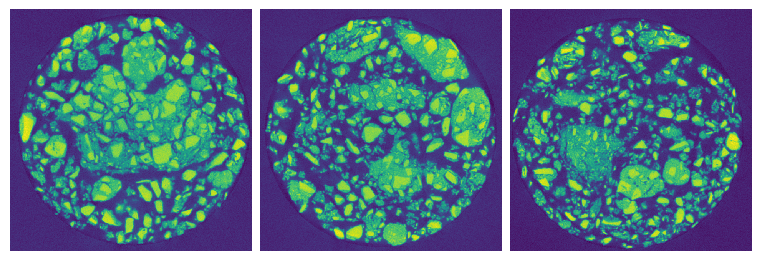

In [2]:
#-------------#
# Load images #
#-------------#
# row & col crop deterined in NB 14
slices = [100, 450, 800]
imgs = segment.load_images(
    ct_dir_path,
    slice_crop=None,
    row_crop=[200, 830],
    col_crop=[190, 820],
    convert_to_float=True,
    file_suffix='.tiff'
)
fig, axes = view.plot_slices(
    imgs,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Preprocessing images...
--> Applying median filter...
--> Preprocessing complete
Calculating thresholds from local minima...
--> 3 peak(s) found: [19404, 43552, 50586]
--> 2 minima found: [30423, 48241]


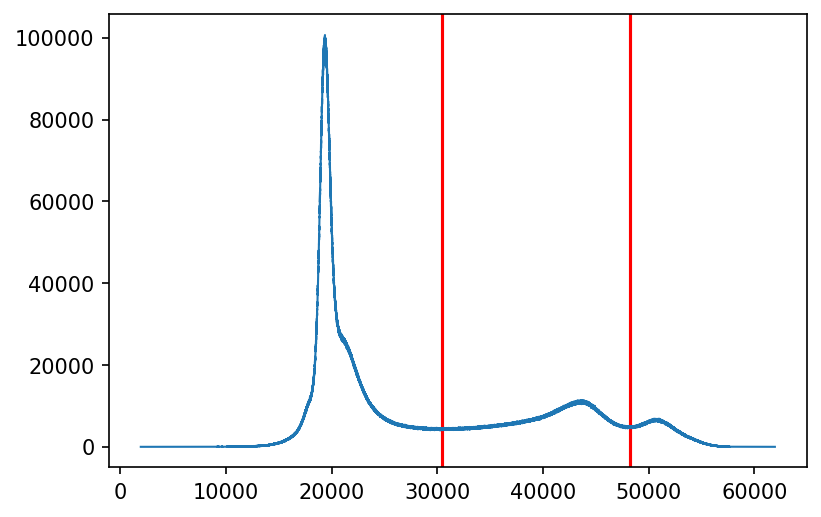

In [3]:
#---------------#
# Median filter #
#---------------#
imgs_med = segment.preprocess(
    imgs, median_filter=True,
    rescale_intensity_range=None
)
# Plot histogram
mins = segment.multi_min_threshold(imgs_med)
hist, hist_centers = exposure.histogram(imgs_med)
fig, ax = plt.subplots(dpi=150)
ax.plot(hist_centers, hist, lw=1)
for min in mins:
    ax.axvline(min, c='red', zorder=0)
plt.show()

Plotting images: [100, 450, 800]


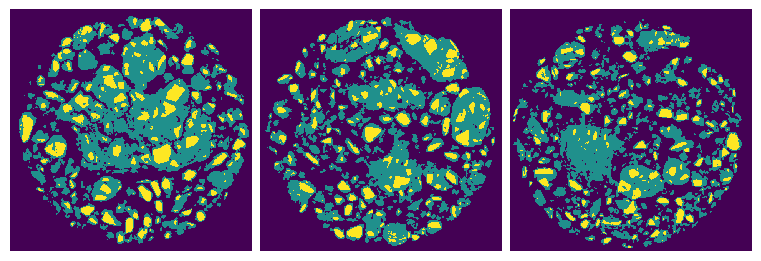

Plotting images: [100, 450, 800]


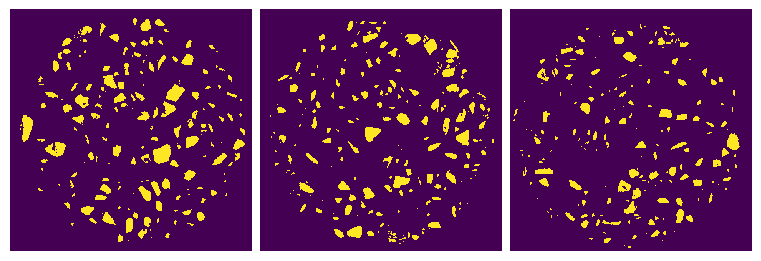

In [4]:
# Plot isolated classes
semantic_seg = segment.isolate_classes(imgs_med, mins)
fig, axes = view.plot_imgs(
    semantic_seg,
    slices=slices,
    fig_w=7.5,
    dpi=100
)
plt.show()
# Plot binarized images
imgs_binarized = imgs_med > mins[-1]
fig, axes = view.plot_slices(
    imgs_binarized,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)
plt.show()

Segmenting images...
--> Segmentation complete. 13789 particle(s) segmented.


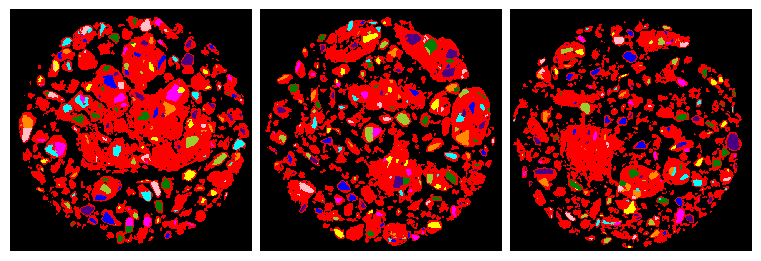

In [5]:
#-----------------------#
# Instance segmentation #
#-----------------------#
labeled_grains = segment.watershed_segment(
    imgs_binarized,
    min_peak_distance=7,
    use_int_dist_map=False,
    exclude_borders=False,
    return_dict=False
)
# Create new array that will represent labeled particles and binder
labeled_grains_binder = labeled_grains.copy()
# Replace any pixels with value 1 with an unused value so included as binder
labeled_grains_binder[labeled_grains_binder == 1] = (
    labeled_grains_binder.max() + 1
)
# Set locations where binder exist (igms_thresh == 1) to 1 in new array
labeled_grains_binder[semantic_seg == 1] = 1
# Visualize instance segmented grains with binder
imgs_color = []
for slice_i in slices:
    imgs_color.append(
        color.label2rgb(labeled_grains_binder[slice_i, ...], bg_label=0)
    )
fig, axes = view.plot_images(
    imgs_color,
    fig_w=7.5,
    dpi=100
)

In [ ]:
# Save array of labeled grains and binder
# void = 0, binder = 1, grains = 2 to N + 1
if save_images:
    segment.save_images(labeled_grains_binder, save_dir_path)